In [14]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import pandas as pd
import numpy as np
import random
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

In [15]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [16]:
synonyms = pd.read_csv("synonym.csv")
print(synonyms)
models= {}

       question        answer              0               1              2  \
0    enormously  tremendously  appropriately        uniquely   tremendously   
1    provisions  stipulations   stipulations  interrelations  jurisdictions   
2   haphazardly      randomly    dangerously         densely       randomly   
3     prominent   conspicuous       battered         ancient     mysterious   
4        zenith      pinnacle     completion        pinnacle         outset   
..          ...           ...            ...             ...            ...   
75      fashion        manner         ration          fathom          craze   
76     marketed          sold         frozen            sold      sweetened   
77       bigger        larger       steadier          closer         larger   
78        roots       origins        origins         rituals           cure   
79     normally    ordinarily      haltingly      ordinarily    permanently   

                  3  
0         decidedly  
1   int

In [17]:
def preprocess_book(book_text):
    sentences = sent_tokenize(book_text)
    cleaned_data=[]
    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        cleaned_data.append(sentence)
    tokenized_sentences = [word_tokenize(cleaned_sentence.lower()) for cleaned_sentence in cleaned_data]

    return tokenized_sentences

In [18]:
file_paths = ['text/The_Wizard_of_Light.txt',
              'text/BURDEN_the_Hand.txt',
              'text/OZYMANDIAS.txt',
              'text/THE_FOG_PRINCES.txt',
              'text/there_was_an_old_WOMAN.txt',
              
              'text2/A_Tale_of_Two_Cities.txt',
              'text2/Adventures_of_Huckleberry_Finn.txt',
              'text2/BOMBA_THE_JUNGLE_BOY_ON_JAGUAR_ISLAND.txt',
              'text2/Travels_in_Western_Africa.txt',
              'text2/women_of_the_war.txt',
              
              'text3/children_of_men.txt',
              'text3/CITIZEN_OR_SUBJECT.txt',
              'text3/DRACULA.txt',
              'text3/Great_Expectations.txt',
              'text3/STUDIES_IN_THE_HISTORY_AND_METHOD_OF_SCIENCE.txt',
              
              'text4/Bleak_House.txt',
              'text4/Don_Quixote.txt',
              'text4/Les_Misérables.txt',
              'text4/The_Count_of_Monte_Cristo.txt',
              'text4/War_and_Peace.txt',
              
              'text5/Anna_Karenina.txt',
              'text5/Middlemarch.txt',
              'text5/Moby_Dick.txt',
              'text5/Notre-Dame_de_Paris.txt',
              'text5/The_Brother_Karamazov.txt']

all_text = []
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        book_text = file.read()
    book_text_processed = preprocess_book(book_text)
    all_text += book_text_processed


In [19]:
def get_answers(model, synonyms):
  output = {"question": [], "answer": [], "model_answer": [], "label": []}
  for index, row in synonyms.iterrows():
    question = row['question']
    answer = row['answer']
    options = [row['0'], row['1'], row['2'], row['3']]
    existed_words = [option for option in options if option in model]
        
    if question in model and len(existed_words)>0:  
      sorted_answers = list(sorted(existed_words, key=lambda x: model.similarity(question, x)))
      model_answer = sorted_answers[-1]
                    
      if model_answer == answer:
        label = "correct"
      else:
        label = "wrong"
                    
    else:
      model_answer = random.choice(options)
      label = "guess"

    output["question"].append(question)
    output["answer"].append(answer)
    output["model_answer"].append(model_answer)
    output["label"].append(label)
                    
  return pd.DataFrame(data=output)

In [20]:
def get_graph_for_analysis(filename):
    df = pd.read_csv(filename)
    label_mapping = {'correct': 1, 'guess': 0, 'wrong': -1}
    df['label_mapped'] = df['label'].map(label_mapping)
    plt.figure(figsize=(90, 6))
    plt.bar(df['question'], df['label_mapped'], color='green')
    plt.xlabel('Question')
    plt.ylabel('Label')
    plt.title('Label Visualization')
    plt.show()

In [21]:
def get_pie_chart_for_analysis(filename):
    df = pd.read_csv(filename)
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(3, 3))
    plt.pie(np.array(label_counts.values), labels =label_counts.index.values, startangle=90, autopct='%1.1f%%')
    plt.title('Percentage of Labels in ' + filename)

In [22]:
print(len(all_text))

218735


# model_1 with embedding size =10, window size=4

In [23]:
model_ebook_1 = Word2Vec(sentences=all_text, window=4, vector_size=10)

In [24]:
models['model_ebook_1-10-4'] = model_ebook_1.wv
print(list(models.keys()))

['model_ebook_1-10-4']


In [25]:
word_vector = model_ebook_1.wv['mare']
word_vector2 = model_ebook_1.wv['monkey']
print(word_vector)
print(word_vector2)

[ 0.47404566  0.32130912  0.5622832   0.17735983  0.865589    0.2275529
  0.27599043  0.5596419  -0.50841594  0.16221654]
[ 0.6939212   0.36442977  0.590306    0.11181624  0.40632778  0.5213726
  0.17465457  0.792798   -0.8173778   0.06166635]


In [26]:
model_ebook_1_answer = get_answers(model_ebook_1.wv, synonyms)
model_ebook_1_answer.to_csv("model_ebook_1-10-4-details.csv")
print(model_ebook_1_answer)

       question        answer   model_answer    label
0    enormously  tremendously  appropriately    wrong
1    provisions  stipulations  jurisdictions    wrong
2   haphazardly      randomly       linearly    guess
3     prominent   conspicuous    conspicuous  correct
4        zenith      pinnacle         outset    wrong
..          ...           ...            ...      ...
75      fashion        manner         manner  correct
76     marketed          sold           sold    guess
77       bigger        larger         larger  correct
78        roots       origins       function    wrong
79     normally    ordinarily   periodically    guess

[80 rows x 4 columns]


# model_2 with embedding size =10, window size=8

In [27]:
model_ebook_2 = Word2Vec(sentences=all_text, window=8, vector_size=10)

In [28]:
models['model_ebook_2-10-8'] = model_ebook_2.wv
print(list(models.keys()))

['model_ebook_1-10-4', 'model_ebook_2-10-8']


In [29]:
model_ebook_2_answer = get_answers(model_ebook_2.wv, synonyms)
model_ebook_2_answer.to_csv("model_ebook_2-10-8-details.csv")
print(model_ebook_2_answer)

       question        answer   model_answer    label
0    enormously  tremendously  appropriately    wrong
1    provisions  stipulations  jurisdictions    wrong
2   haphazardly      randomly       randomly    guess
3     prominent   conspicuous    conspicuous  correct
4        zenith      pinnacle       pinnacle  correct
..          ...           ...            ...      ...
75      fashion        manner         manner  correct
76     marketed          sold         frozen    guess
77       bigger        larger         larger  correct
78        roots       origins       function    wrong
79     normally    ordinarily      haltingly    guess

[80 rows x 4 columns]


# model_3 with embedding size =20, window size=4

In [30]:
model_ebook_3 = Word2Vec(sentences=all_text, window=4, vector_size=20)

In [31]:
models['model_ebook_3-20-4'] = model_ebook_3.wv
print(list(models.keys()))

['model_ebook_1-10-4', 'model_ebook_2-10-8', 'model_ebook_3-20-4']


In [32]:
model_ebook_3_answer = get_answers(model_ebook_3.wv, synonyms)
model_ebook_3_answer.to_csv("model_ebook_3-20-4-details.csv")
print(model_ebook_3_answer)

       question        answer   model_answer    label
0    enormously  tremendously   tremendously  correct
1    provisions  stipulations  jurisdictions    wrong
2   haphazardly      randomly    dangerously    guess
3     prominent   conspicuous    conspicuous  correct
4        zenith      pinnacle         outset    wrong
..          ...           ...            ...      ...
75      fashion        manner         manner  correct
76     marketed          sold      sweetened    guess
77       bigger        larger         larger  correct
78        roots       origins       function    wrong
79     normally    ordinarily     ordinarily    guess

[80 rows x 4 columns]


# model_4 with embedding size =20, window size=8

In [37]:
model_ebook_4 = Word2Vec(sentences=all_text, window=8, vector_size=20)

In [34]:
models['model_ebook_4-20-8'] = model_ebook_4.wv
print(list(models.keys()))

['model_ebook_1-10-4', 'model_ebook_2-10-8', 'model_ebook_3-20-4', 'model_ebook_4-20-8']


In [38]:
model_ebook_4_answer = get_answers(model_ebook_4.wv, synonyms)
model_ebook_4_answer.to_csv("model_ebook_4-20-8-details.csv")
print(model_ebook_4_answer)

       question        answer   model_answer    label
0    enormously  tremendously  appropriately    wrong
1    provisions  stipulations  jurisdictions    wrong
2   haphazardly      randomly        densely    guess
3     prominent   conspicuous    conspicuous  correct
4        zenith      pinnacle       pinnacle  correct
..          ...           ...            ...      ...
75      fashion        manner         manner  correct
76     marketed          sold           sold    guess
77       bigger        larger         larger  correct
78        roots       origins       function    wrong
79     normally    ordinarily      haltingly    guess

[80 rows x 4 columns]


# Analysis

In [40]:
analysis = {"model": [], "vocabulary": [], "correct": [], "answered": [], "accuracy": []} 

for model in models:
  output_file = f"{model}-details.csv"
  output = pd.read_csv(output_file)

  correct_count = len([True for label in output["label"] if label == "correct"])
  answered_count = len([True for label in output["label"] if label != "guess"])

  analysis["model"].append(model)
  analysis["vocabulary"].append(len(models[model].index_to_key))
  analysis["correct"].append(correct_count)
  analysis["answered"].append(answered_count)
  analysis["accuracy"].append(correct_count / answered_count if answered_count > 0 else 0)

analysis = pd.DataFrame(data=analysis)
print(analysis)

analysis_file = pd.read_csv("analysis.csv")

updated_analysis = pd.concat([analysis_file, analysis], ignore_index=True)

updated_analysis.to_csv("analysis.csv", index=False)

                model  vocabulary  correct  answered  accuracy
0  model_ebook_1-10-4       26506       19        67  0.283582
1  model_ebook_2-10-8       26506       25        67  0.373134
2  model_ebook_3-20-4       26506       25        67  0.373134
3  model_ebook_4-20-8       26506       28        67  0.417910


# Graph for Results

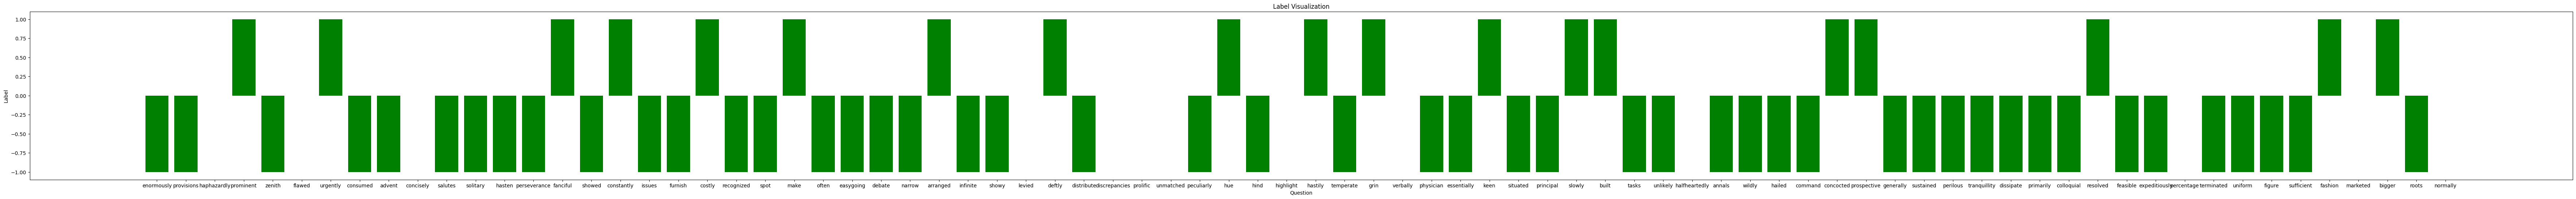

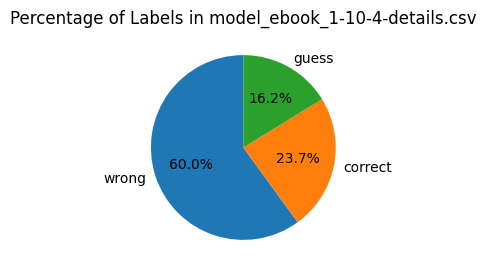

In [41]:
get_graph_for_analysis("model_ebook_1-10-4-details.csv")
get_pie_chart_for_analysis("model_ebook_1-10-4-details.csv")

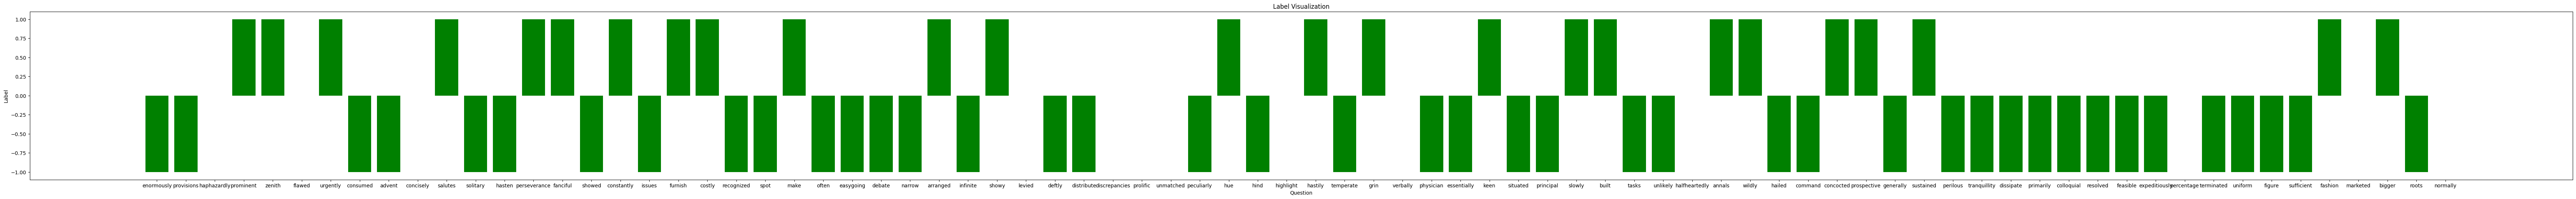

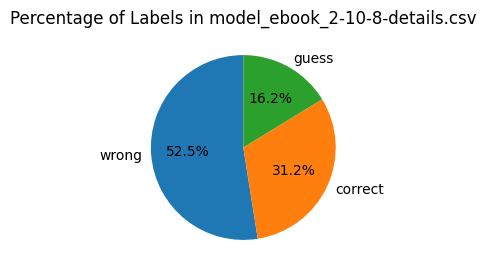

In [42]:
get_graph_for_analysis("model_ebook_2-10-8-details.csv")
get_pie_chart_for_analysis("model_ebook_2-10-8-details.csv")

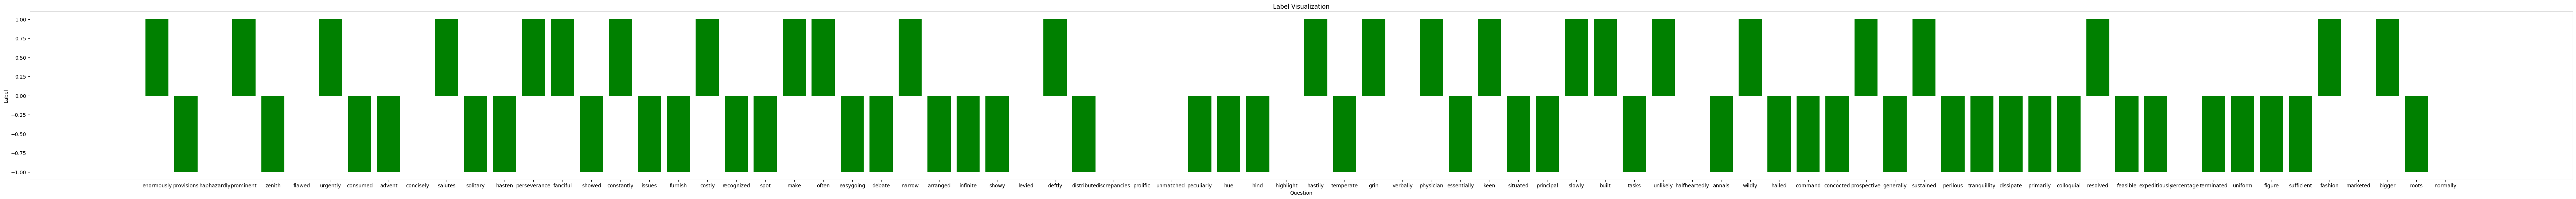

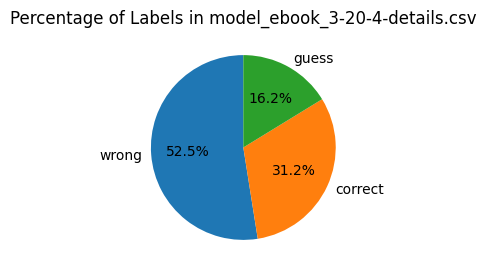

In [43]:
get_graph_for_analysis("model_ebook_3-20-4-details.csv")
get_pie_chart_for_analysis("model_ebook_3-20-4-details.csv")

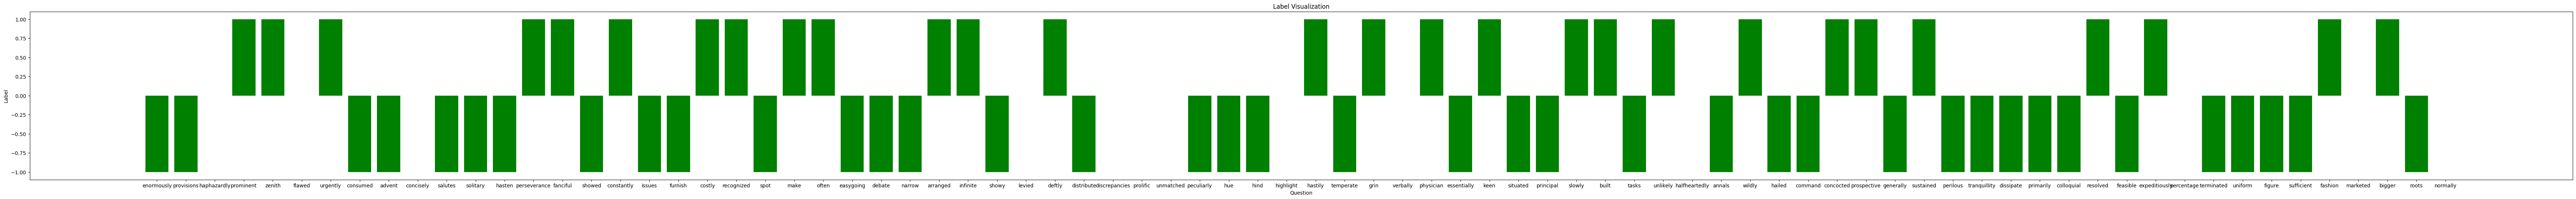

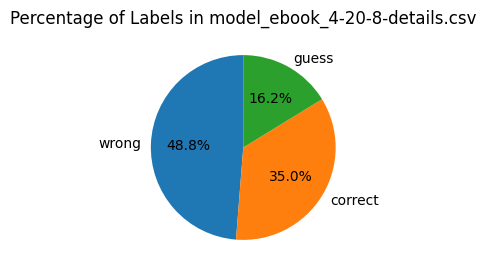

In [44]:
get_graph_for_analysis("model_ebook_4-20-8-details.csv")
get_pie_chart_for_analysis("model_ebook_4-20-8-details.csv")